In [1]:
# # Reading the Gene Expressions
# # ----------------------------
# gene_expressions_raw = pd.read_csv("C:\My-Study\# Semester 2 - Spring 2022\INFO-I-519 - Machine Learning Bioinformatics\Project (Final)\Gene Expression Files\CosmicCLP_RawGeneExpression.tsv", sep = '\t')
# gene_expressions_raw.head()
# gene_expressions_complete = pd.read_csv("C:\My-Study\# Semester 2 - Spring 2022\INFO-I-519 - Machine Learning Bioinformatics\Project (Final)\Gene Expression Files\CosmicCLP_CompleteGeneExpression.tsv", sep = '\t')
# gene_expressions_complete.head()

In [11]:
gene_expressions_complete['REGULATION'].value_counts()

normal    14772853
over        568961
under       418746
Name: REGULATION, dtype: int64

<br><br><br><br>
### Link


`GNN to generate drug fingerprints - rich molecular representation. <br>
https://towardsdatascience.com/practical-graph-neural-networks-for-molecular-machine-learning-5e6dee7dc003`
<br><br><br><br>

#### NEW APPROACH: GCN + GNN + DNN ( ALL IN SAME ARCHITECTURE)

In [7]:
df_labels = pd.read_csv("C:\My-Study\# Semester 2 - Spring 2022\INFO-I-519 - Machine Learning Bioinformatics\Project (Final)\Datasets\Final Dataset\labels.csv")
df_smiles = pd.read_csv("C:\My-Study\# Semester 2 - Spring 2022\INFO-I-519 - Machine Learning Bioinformatics\Project (Final)\Datasets\Final Dataset\smiles.csv")

print("======================================================================")
display(df_labels.head(5))
print("")
display(df_smiles.head(5))
print("======================================================================")

,Unnamed: 0,drug_a_name,drug_b_name,cell_line,synergy,fold
0,5-FU_ABT-888_A2058,5-FU,ABT-888,A2058,7.693530,2
1,5-FU_ABT-888_A2780,5-FU,ABT-888,A2780,7.778053,2
2,5-FU_ABT-888_A375,5-FU,ABT-888,A375,-1.198505,2
3,5-FU_ABT-888_A427,5-FU,ABT-888,A427,2.595684,2
4,5-FU_ABT-888_CAOV3,5-FU,ABT-888,CAOV3,-5.139971,2


,drug_b_name,smiles
0,5-FU,O=c1[nH]cc(F)c(=O)[nH]1
1,ABT-888,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,AZD1775,C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...
3,BEZ-235,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...
4,BORTEZOMIB,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O


In [8]:
df = df_smiles.copy()
df['synergy_scores'] = np.random.uniform(size=len(df))
df.head()

,drug_b_name,smiles,synergy_scores
0,5-FU,O=c1[nH]cc(F)c(=O)[nH]1,0.754508
1,ABT-888,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.330773
2,AZD1775,C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...,0.008372
3,BEZ-235,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...,0.916437
4,BORTEZOMIB,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O,0.410857


In [9]:
# df = pd.read_csv('dataset2/smiles.csv', header=None)
# df.columns = ['Drug', 'Structure']
# random_values = np.random.uniform(size=len(df))
# df['synergy_scores'] = random_values
# df.head()


### GNN for message passing NN

In [10]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [11]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


In [14]:

# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].synergy_scores

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].synergy_scores

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].synergy_scores

Name of the Drug:  DOXORUBICIN
Smiles          :  COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1
Synergy Score   :  0.6032111875192352
Molecule:


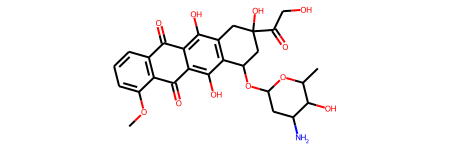

In [18]:
# Looking at one molecule


print("Name of the Drug: ", df.drug_b_name[10])
print("Smiles          : ", df.smiles[10])
print("Synergy Score   : ", df.synergy_scores[10])

molecule = molecule_from_smiles(df.iloc[10].smiles)
print("Molecule:")
display(molecule)

In [19]:
# Looking at it's graphical structure:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (39, 29)
	bond features	 (125, 7)
	pair indices	 (125, 2)


In [20]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [21]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [22]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

In [23]:
def MPNNModel(
    input_layer_names,
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512
):

    atom_features = layers.Input((atom_dim), dtype="float32", name=input_layer_names[0])
    bond_features = layers.Input((bond_dim), dtype="float32", name=input_layer_names[1])
    pair_indices = layers.Input((2), dtype="int32", name=input_layer_names[2])
    molecule_indicator = layers.Input((), dtype="int32", name=input_layer_names[3])

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

#     x = layers.Dense(dense_units, activation="relu")(x)
#     x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices],
        outputs=[x],
    )
    return model, x


In [24]:

full_model = tf.keras.Model(inputs=[mpnn1.input], outputs=[output])

print(full_model.summary())

NameError: name 'mpnn1' is not defined

In [106]:
mpnn1.input

[<KerasTensor: shape=(None, 29) dtype=float32 (created by layer 'atom_features_d1')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'bond_features_d1')>,
 <KerasTensor: shape=(None, 2) dtype=int32 (created by layer 'pair_indices_d1')>,
 <KerasTensor: shape=(None,) dtype=int32 (created by layer 'molecule_indicator_d1')>]

In [125]:
 tf.data.Dataset.from_tensor_slices(((x_train,x_train), (y_train)))

<TensorSliceDataset element_spec=(((RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int64)), (RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int64))), TensorSpec(shape=(), dtype=tf.float64, name=None))>

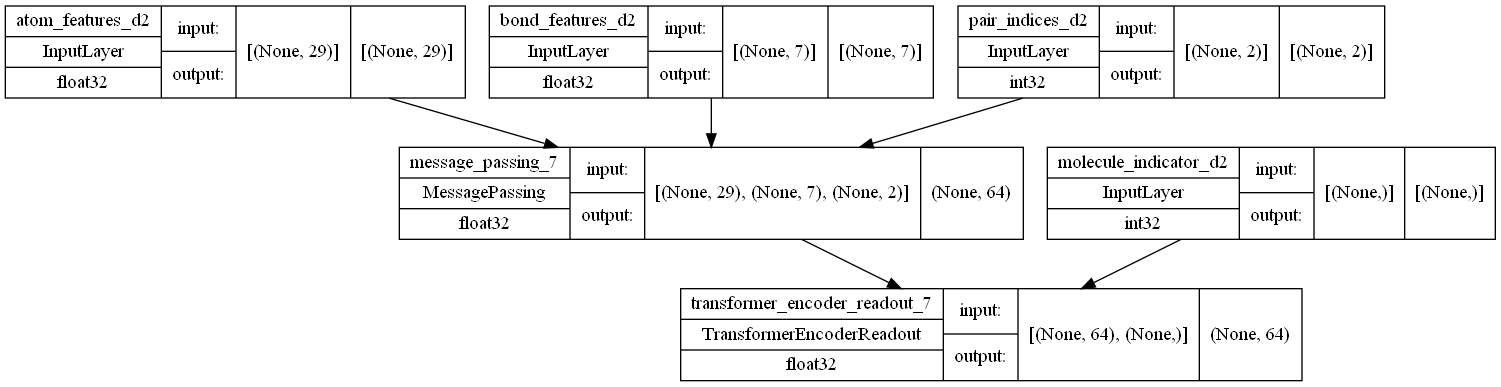

In [63]:
mpnn2, x2 = MPNNModel(
    ["atom_features_d2", "bond_features_d2", "pair_indices_d2", "molecule_indicator_d2"], atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

# mpnn.compile(
#     loss=keras.losses.BinaryCrossentropy(),
#     optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#     metrics=[keras.metrics.AUC(name="AUC")],
# )

keras.utils.plot_model(mpnn2, show_dtype=True, show_shapes=True)

In [67]:
x2

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'transformer_encoder_readout_7')>

In [65]:
for layer in mpnn1.layers:
    print(layer.name)

atom_features_d1
bond_features_d1
pair_indices_d1
message_passing_6
molecule_indicator_d1
transformer_encoder_readout_6


In [38]:
mpnn1.get_layer('transformer_encoder_readout_3')


In [72]:
# Concatenate
concat = tf.keras.layers.Concatenate()([x1, x2])

n_classes = 1
# some hidden layers and an output layer
dense_1 = tf.keras.layers.Dense(64,
                               activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32,
                               activation=tf.keras.activations.relu)(dense_1)
output = tf.keras.layers.Dense(units=n_classes,
                               activation=tf.keras.activations.linear)(dense_2)

In [75]:
all_inputs = []
for i in mpnn1.input:
    all_inputs.append(i)
for i in mpnn2.input:
    all_inputs.append(i)


full_model = tf.keras.Model(inputs=[mpnn1.input, mpnn2.input], outputs=[output])

print(full_model.summary())

# keras.utils.plot_model(full_model, show_dtype=True, show_shapes=True)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features_d1 (InputLayer)  [(None, 29)]         0           []                               
                                                                                                  
 bond_features_d1 (InputLayer)  [(None, 7)]          0           []                               
                                                                                                  
 pair_indices_d1 (InputLayer)   [(None, 2)]          0           []                               
                                                                                                  
 atom_features_d2 (InputLayer)  [(None, 29)]         0           []                               
                                                                                           

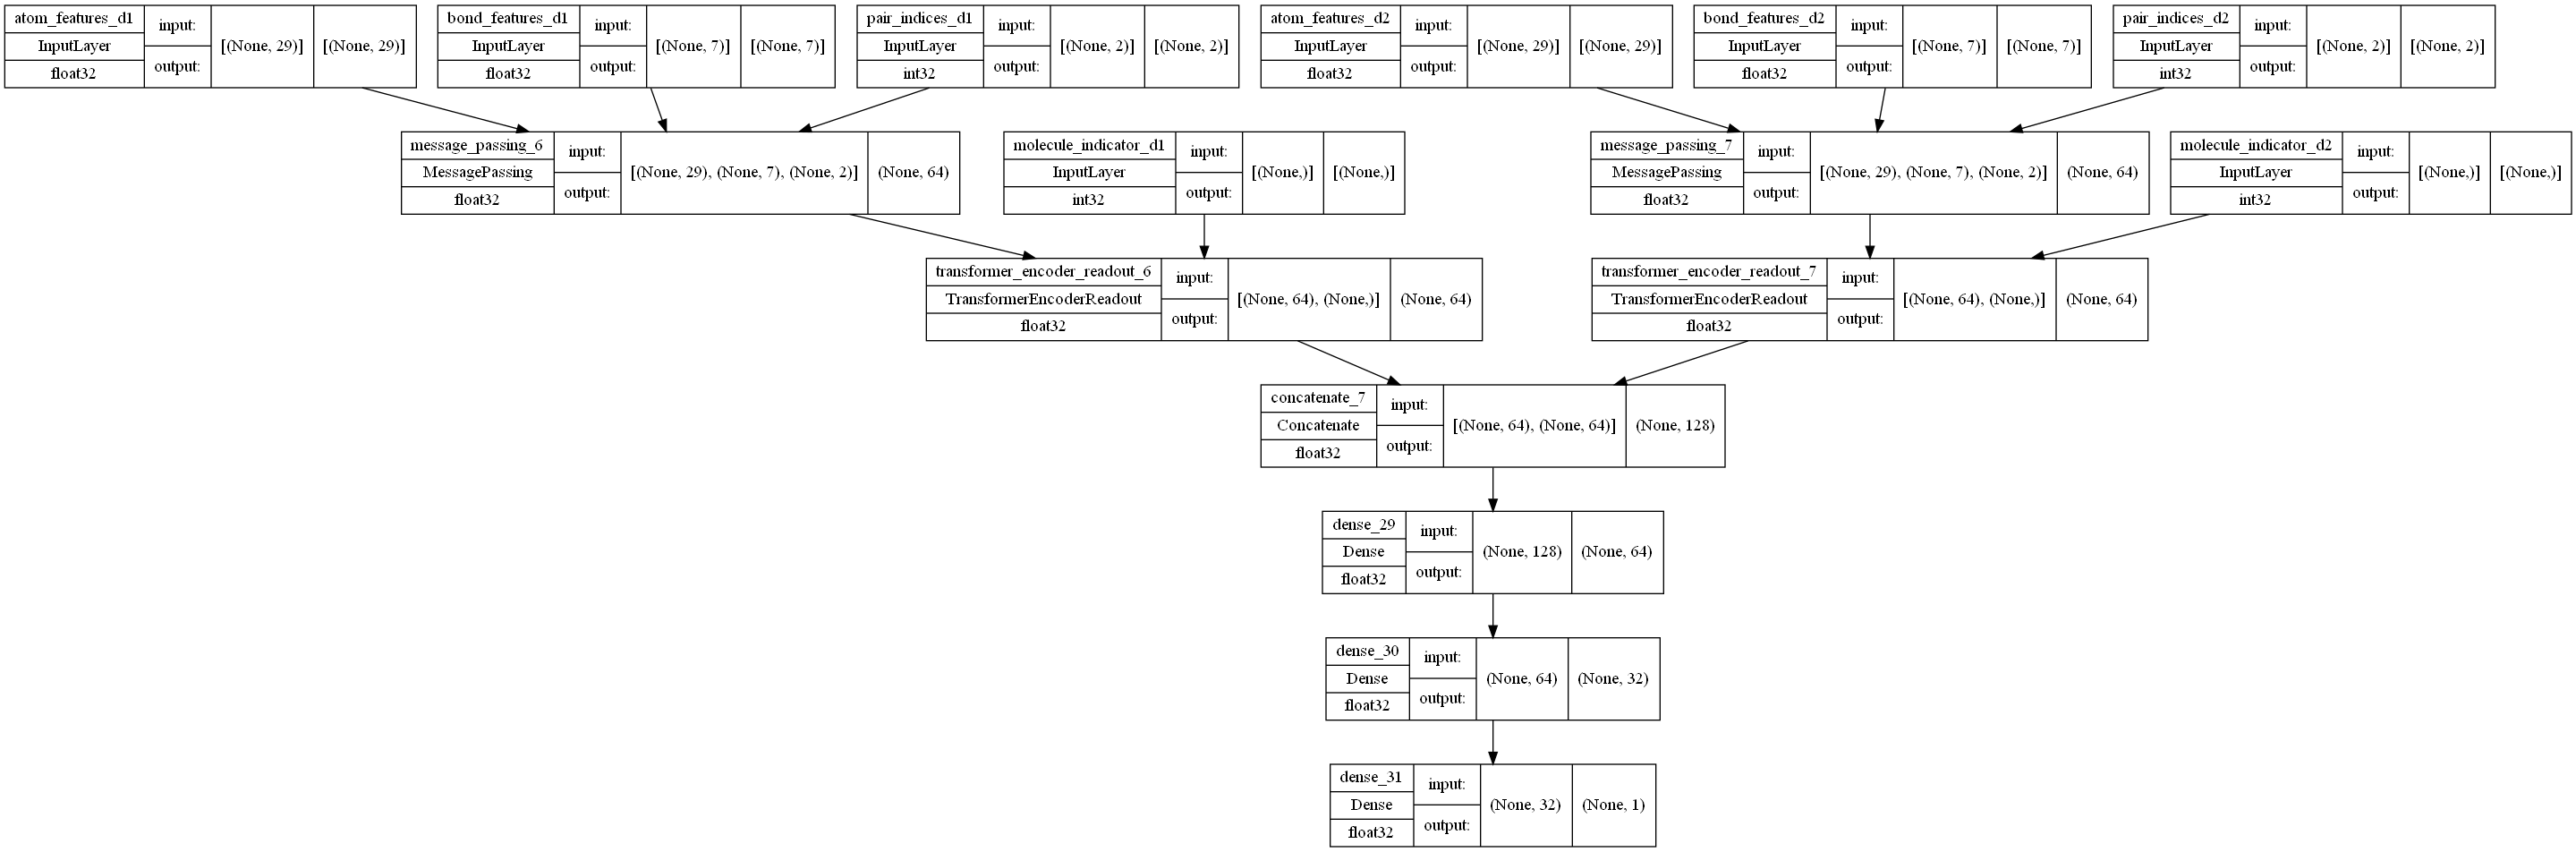

In [76]:
# Compile combined model and evaluate metrics

full_model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanSquaredError()],
)

keras.utils.plot_model(full_model, show_dtype=True, show_shapes=True)

In [81]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

In [128]:
full_model

In [89]:
history = full_model.fit(
    [train_dataset,train_dataset],
    epochs=40,
    verbose=2
)


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>"}), <class 'NoneType'>

<PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>